# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

En este cuaderno buscaremos elaborar un modelo predictivo utilizando Machine Learning para saber una estimación del precio de un determinado vehículo de segunda mano y poder optimizar la compraventa de coches.

Por esto, el objetivo es tener una plataforma web donde poder saber el precio de un determinado vehículo de segunda mano, en base al precio de otros coches registrados en nuestra base de datos. Para ello, se utilizan los registros guardados en la tabla TX_VEHICULOS_SEG_MANO de nuestra BBDD de sqlite, con cerca de 35.000 registros de vehículos de 10 marcas diferentes importadas desde un Dataset de Kaggle hecho a partir de WebScraping, a los que hemos añadido X vehículos scrapeados mediante el script guardado en la ruta ```"dags/webscraping_script.py"``` de la página de [coches.net](coches.net).

Los registros obtenidos mediante ambos orígenes de datos han sido posibles de combinar mediante las transformaciones realizadas en el cuaderno ```"notebooks/kaggle_dataset_cleaning.ipynb"```, aunque antes de entrenar el modelo predictivo será necesario realizar algunas transformaciones adicionales, así como seleccionar las features del modelo.

En este proyecto, se utilizarán modelos de Machine Learning para calcular el precio de un coche a partir de características como la marca, modelo, tipo de combustible, año, etc. Se trata, por tanto, de un problema de regresión. Se utilizará como métrica de optimización el Mean Squared Error (MSE), aunque también se analizarán otras métricas como el Mean Average Error (MAE).

## 2. Obtención y procesado de datos.

Importamos los datos desde nuestra base de datos:

In [1]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set_style("darkgrid")


colors = ["#d5001c", "#f59908", "#ffcb01", "#969696"]

In [2]:
import sqlite3
import pandas as pd

con = sqlite3.connect("../include/db_vehiculos.db")

query = """
SELECT *
FROM TX_VEHICULOS_SEG_MANO
where
    --origen_anuncio = 'WebScraping'
    --origen_anuncio = 'dataset kaggle'
    --and marca not in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
    marca in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
order by
    fecha_carga desc
;
"""

df = pd.read_sql_query(query, con)

df.head()

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60545114,CITROEN,c4 picasso,7999.0,Diésel,2014.0,195000,115.0,5.0,5.0,...,Monovolumen,1560.0,negro,Barcelona,B (amarilla),WebScraping,2025-05-27,202505,2025-05-27 10:50:08,https://www.coches.net/citroen-c4-picasso-16-e...
1,60657064,OPEL,corsa,11985.0,Gasolina,2020.0,32325,100.0,5.0,5.0,...,Berlina,1364.0,blanco,Sta. C. Tenerife,C (verde),WebScraping,2025-05-27,202505,2025-05-27 10:49:44,https://www.coches.net/opel-corsa-14-turbo-74k...
2,60656553,OPEL,corsa,14990.0,Gasolina,2022.0,63540,130.0,5.0,5.0,...,Berlina,1199.0,azul,Valencia,None,WebScraping,2025-05-27,202505,2025-05-27 10:48:33,https://www.coches.net/opel-corsa-12t-xht-96kw...
3,60659620,CITROEN,berlingo,9990.0,Gasolina,2018.0,110000,110.0,5.0,5.0,...,Monovolumen,1199.0,gris,Sta. C. Tenerife,None,WebScraping,2025-05-27,202505,2025-05-27 10:47:11,https://www.coches.net/citroen-berlingo-talla-...
4,60659465,AUDI,a3,29150.0,Híbrido,2020.0,82351,150.0,5.0,5.0,...,Berlina,1498.0,azul,Madrid,ECO (azul/verde),WebScraping,2025-05-27,202505,2025-05-27 10:37:06,https://www.coches.net/audi-a3-sportback-genui...


Podemos ver el número de registros para cada origen de datos:

In [3]:
df['origen_anuncio'].value_counts()

origen_anuncio
dataset kaggle    35041
WebScraping        5002
Name: count, dtype: int64

Vemos que la gran mayoría de registros provienen del dataset de kaggle.

Vamos a ver qué columnas contiene el DataFrame:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40043 entries, 0 to 40042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        40043 non-null  int64  
 1   marca                40043 non-null  object 
 2   modelo               40043 non-null  object 
 3   precio               40043 non-null  float64
 4   combustible          39843 non-null  object 
 5   anyo_vehiculo        40042 non-null  float64
 6   kilometraje          40043 non-null  int64  
 7   potencia             33150 non-null  float64
 8   num_puertas          39931 non-null  float64
 9   num_plazas           4886 non-null   float64
 10  tipo_cambio          39963 non-null  object 
 11  tipo_vehiculo        5002 non-null   object 
 12  cilindrada_motor     4864 non-null   float64
 13  color                39424 non-null  object 
 14  provincia            40039 non-null  object 
 15  etiqueta_eco         3306 non-null  

Vemos que el DataFrame se compone de 21 columnas, de las cuales, muchas de ellas son de tipo string. Además, contienen valores nulos, por lo que, a continuación, haremos un procesado de estas columnas.

La columna target u objetivo a predecir es la columna llamada ```"precio"```.

Lo primero que haremos es eliminar las columnas ```['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco']```, ya que solo tienen valores no nulos para los registros obtenidos mediante WebScraping.

In [5]:
df = df.drop(columns=['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40043 entries, 0 to 40042
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        40043 non-null  int64  
 1   marca                40043 non-null  object 
 2   modelo               40043 non-null  object 
 3   precio               40043 non-null  float64
 4   combustible          39843 non-null  object 
 5   anyo_vehiculo        40042 non-null  float64
 6   kilometraje          40043 non-null  int64  
 7   potencia             33150 non-null  float64
 8   num_puertas          39931 non-null  float64
 9   tipo_cambio          39963 non-null  object 
 10  color                39424 non-null  object 
 11  provincia            40039 non-null  object 
 12  origen_anuncio       40043 non-null  object 
 13  fecha_publicacion    40043 non-null  object 
 14  anyomes_publicacion  40043 non-null  int64  
 15  fecha_carga          40043 non-null 

Vamos a eliminar también las columnas: ```['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url']```, ya que tampoco aportan información para el modelo.

De momento dejamos la columna ```'origen_anuncio'``` por si hay que distinguir en alguna transformación entre los datos de ambos orígenes.

In [6]:
df = df.drop(columns=['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40043 entries, 0 to 40042
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40043 non-null  object 
 1   modelo          40043 non-null  object 
 2   precio          40043 non-null  float64
 3   combustible     39843 non-null  object 
 4   anyo_vehiculo   40042 non-null  float64
 5   kilometraje     40043 non-null  int64  
 6   potencia        33150 non-null  float64
 7   num_puertas     39931 non-null  float64
 8   tipo_cambio     39963 non-null  object 
 9   color           39424 non-null  object 
 10  origen_anuncio  40043 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.4+ MB


### Variable objetivo: precio.

Vamos a ver la distibución de datos de la columna target (```"precio"```):

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

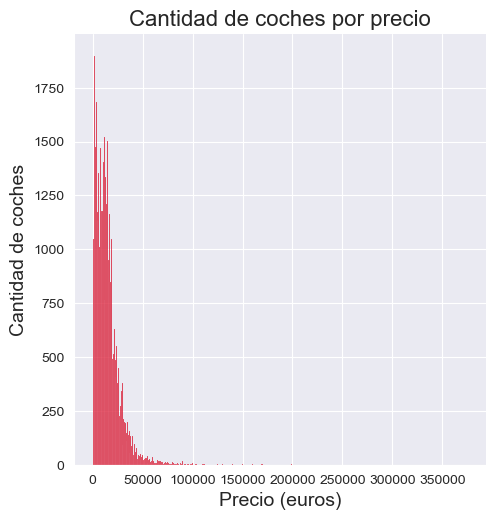

In [7]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio", fontsize=16)

plt.xlabel("Precio (euros)", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.show()

Vemos que existen muchos coches con un precio más bajo, y que, para precios más elevados, se reduce el número. Para corregir esto, y aumentar la eficacia del modelo predictivo, vamos a tomar dos medidas:

1. Realizar un boxplot para detectar outliers y poder eliminar estos registros.

2. Aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Comenzamos realizando el Boxplot:

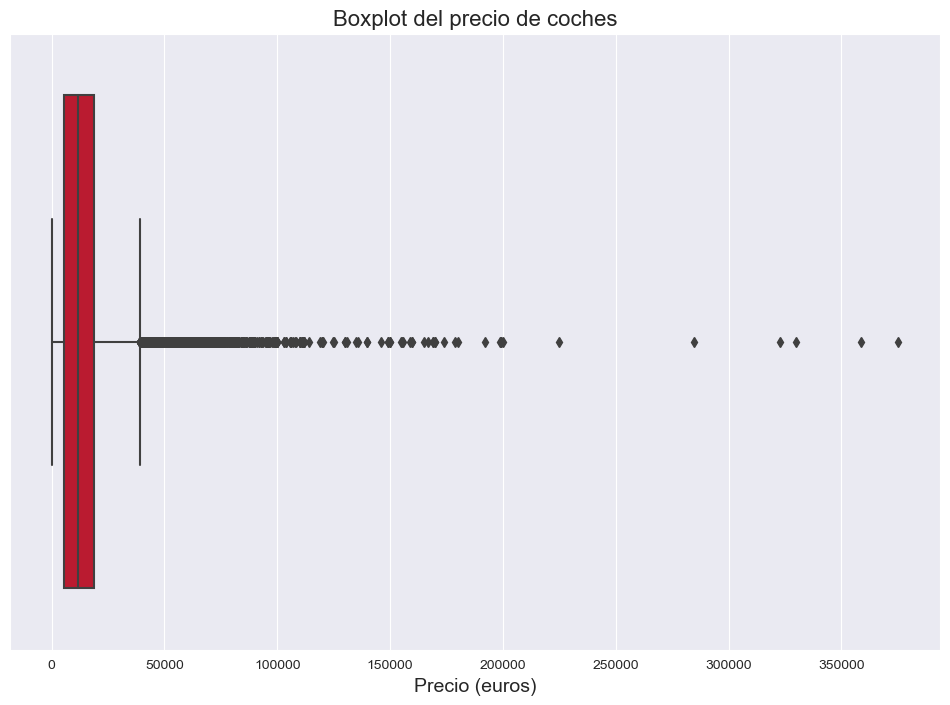

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Boxplot de la variable "precio"
sns.boxplot(x=df["precio"], color=colors[0])

# Títulos y etiquetas
plt.title("Boxplot del precio de coches", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que la distribución del boxplot muestra que el 75 % de los registros se concentran por debajo de los 20.000 euros aproximadamente.

Vamos a ver las principales medidas estadísticas de la variable ```"precio"```:

In [9]:
df["precio"].describe()

count     40043.000000
mean      14331.830382
std       13386.183157
min         300.000000
25%        5500.000000
50%       11900.000000
75%       18900.000000
max      375000.000000
Name: precio, dtype: float64

In [10]:
# df = df.loc[df.loc[:, "precio"] < 101000, :]

Observamos que la variable tiene una media de 14.266 euros y una desviación estándar (sigma) de 13.697 euros. Sin embargo, el valor máximo es de 375.000 euros.

Ante esto, vamos a proponer dos opciones para eliminar outliers que puedan influir negativamente en el modelo o para los cuáles funcione muy mal.

1. Coger los valores dentro de los siguientes límites a partir del Rango intercuartílico (IQR), que marcarían los outliers tradicionales:

    - limite_inferior = Q1 - 1.5 * IQR
    - limite_superior = Q3 + 1.5 * IQR

Probamos esta opción:


Opción con cuartiles:

In [11]:
# Calculamos Q1, Q3 e IQR
Q1 = df["precio"].quantile(0.25)
Q3 = df["precio"].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior para considerar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Límite de precio inferior: {limite_inferior}")
print(f"Límite de precio superior: {limite_superior}")

df_iqr = df[(df["precio"] >= limite_inferior) & (df["precio"] <= limite_superior)]

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_iqr)}")


Límite de precio inferior: -14600.0
Límite de precio superior: 39000.0
Número de coches antes de eliminar outliers: 40043
Número de coches después de eliminar outliers: 38497


Si utilizamos esta opción seguro que el modelo funciona muy bien pero solo predeciríamos vehículos con precios hasta 39.975 euros, lo que dejaría fuera muchos modelos.

Por ello, vamos a descartar esta opción.

Probaremos una segunda opción que consiste en aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Después, nos quedaremos con los vehículos en un rango de valores del precio transformado de 2 desviaciones estandar a partir de la media, que coresponderá a un porcentaje muy elevado de los datos.

Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Aplicamos la transformación logarítmica:

In [12]:
import numpy as np

# Transformación logarítmica del precio:
df["precio"] = np.log(df["precio"])

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

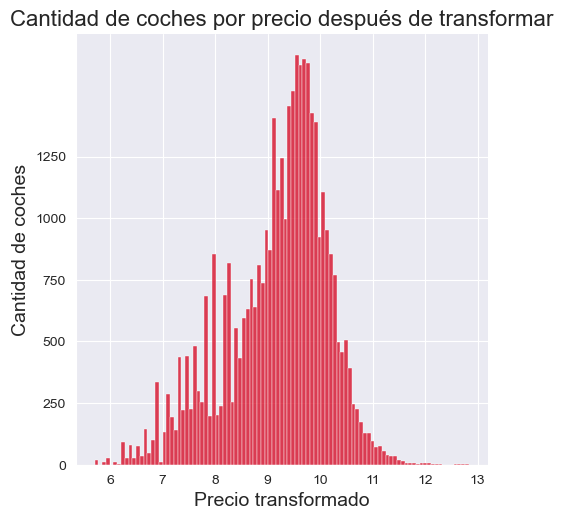

In [13]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio después de transformar", fontsize=16)

plt.xlabel("Precio transformado", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.yticks(range(0, 1500, 250))

plt.show()

Test de normalidad de Shapiro-Wilk:

In [14]:
from scipy.stats import shapiro

# Aplicar el test de Shapiro-Wilk a una muestra (máx. 5000 datos recomendado)
sample = df["precio"].sample(n=5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p_value:.35f}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no siguen una distribución normal.")


Estadístico W: 0.9626
Valor p: 0.00000000000000000000000000000000042
Se rechaza H₀: los datos no siguen una distribución normal.


Nos quedamos con los valores dentro del límite superior de 2 sigmas:

In [15]:
mean_log = df["precio"].mean()
std_log = df["precio"].std()

# Límite superior a 2 sigmas en escala logarítmica:
upper_log_limit = mean_log + 2 * std_log

# Filtramos solo los valores dentro de las 2 sigmas:
df_filtrado = df[df["precio"] <= upper_log_limit]

# (Opcional) Si necesitamos volver a la escala original:
max_precio_filtrado = np.exp(upper_log_limit)

print(f"Límite superior en escala log: {upper_log_limit:.4f}")
print(f"Corresponde a un precio real de: {max_precio_filtrado:,.2f} €")

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_filtrado)}")


Límite superior en escala log: 11.1244
Corresponde a un precio real de: 67,806.08 €
Número de coches antes de eliminar outliers: 40043
Número de coches después de eliminar outliers: 39736


In [16]:
# Estadísticos de la variable precio transfromada:

df["precio"].describe()

count    40043.000000
mean         9.180664
std          0.971872
min          5.703782
25%          8.612503
50%          9.384294
75%          9.846917
max         12.834681
Name: precio, dtype: float64

Vemos que se eliminan 269 registros. Vamos a aplicar la transformación al df original y a ver los valores estadísticos transformados de nuevo, para ver que se ha realizado correctamente:

In [17]:
# Aplicamos el filtro de las 2 sigmas al df original:
df = df[df["precio"] <= upper_log_limit]

# Nuevos estadísticos tras el filtro:
df["precio"].describe()

count    39736.000000
mean         9.163411
std          0.955134
min          5.703782
25%          8.612503
50%          9.380421
75%          9.836946
max         11.119883
Name: precio, dtype: float64

Estos son los estadísticos que contiene la columna ```df["precio"]```, que ahora están en escala logarítmica, vamos a verlos en escala normal deshaciendo la transformación:

In [18]:
import numpy as np

# Mostramos el resumen estadístico con la transformación inversa (precio real)
print(np.exp(df["precio"]).describe())

count    39736.000000
mean     13701.004782
std      10720.172920
min        300.000000
25%       5500.000000
50%      11854.000000
75%      18712.500000
max      67500.000000
Name: precio, dtype: float64


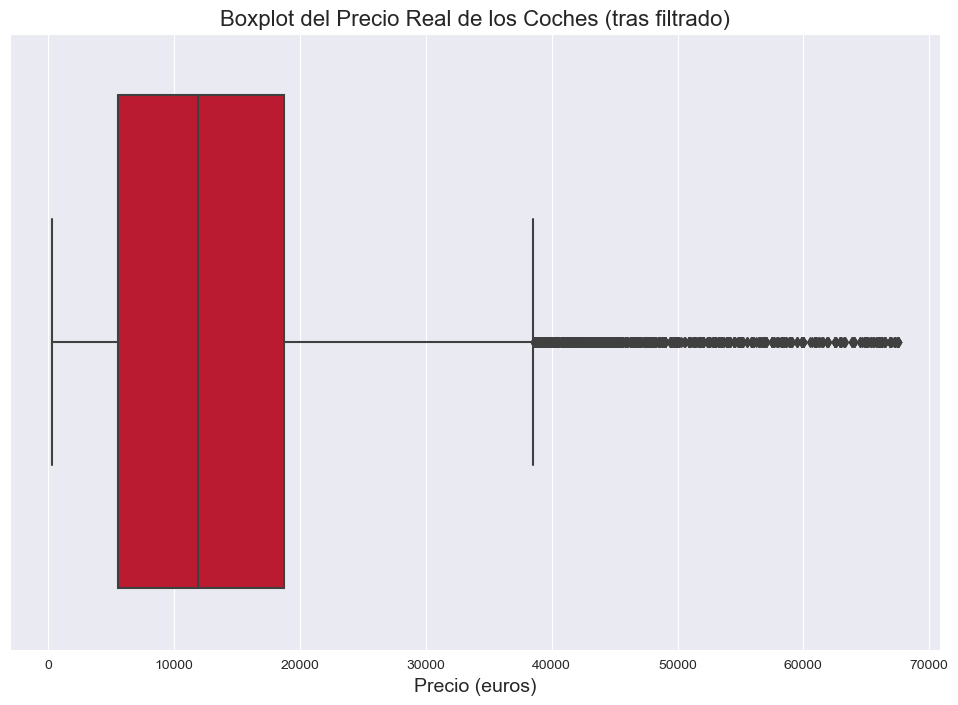

In [19]:
plt.figure(figsize=(12, 8))

# Boxplot con la transformación inversa de log(precio)
sns.boxplot(x=np.exp(df["precio"]), color=colors[0])

plt.title("Boxplot del Precio Real de los Coches (tras filtrado)", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que sólo hemos perdido 269 vehículos pero ahora el precio máximo es de 69.395 euros, lo que comprende más vehículos y elimina outliers que el modelo podría predecir mal.

In [20]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,CITROEN,c4 picasso,8.987072,Diésel,2014.0,195000,115.0,5.0,Manual,negro,WebScraping
1,OPEL,corsa,9.391411,Gasolina,2020.0,32325,100.0,5.0,Manual,blanco,WebScraping
2,OPEL,corsa,9.615139,Gasolina,2022.0,63540,130.0,5.0,Automático,azul,WebScraping
3,CITROEN,berlingo,9.209340,Gasolina,2018.0,110000,110.0,5.0,Manual,gris,WebScraping
4,AUDI,a3,10.280210,Híbrido,2020.0,82351,150.0,5.0,Automático,azul,WebScraping


Vemos que el precio ya no está en euros. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

### Variables numéricas:

#### Potencia:

Vamos a analizar los nulos de la columna ```'potencia'```, a ver si son debidos al tipo de combustible o simplemente falta en esos registros.

In [21]:
df.groupby("combustible")["potencia"].apply(lambda x: x.isnull().sum())

combustible
Diesel                   3
Diésel                4879
Eléctrico                0
Gas licuado (GLP)        0
Gas natural (CNG)        0
Gasolina              1878
Híbrido                  0
Híbrido Enchufable       0
Híbrido enchufable       0
Name: potencia, dtype: int64

Como parece que hay varios formatos de la columna combustible, vamos a mapearlos:

In [22]:

mapa_combustible = {
    "Diesel": "Diésel",
    "Híbrido enchufable": "Híbrido Enchufable",
    "Híbrido Enchufable": "Híbrido Enchufable"
}

df["combustible"] = df["combustible"].replace(mapa_combustible)

In [23]:
df["combustible"].value_counts()

combustible
Diésel                25881
Gasolina              12538
Híbrido Enchufable      376
Híbrido                 343
Eléctrico               291
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

In [24]:
df[df["potencia"].isna()].groupby("combustible").size()

combustible
Diésel      4882
Gasolina    1878
dtype: int64

Observamos que todos los nulos son para vehículos de gasolina o diésel, por lo que vamos a eliminar estos registros del DataFrame, ya que tenemos una cantidad de datos abundante y puede ser un parámetro sensible en el modelo, por lo que tratar de rellenar esos NaN por alguna métrica como la media, puede afectar negativamente.

In [25]:
df = df.drop(index=(df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,CITROEN,c4 picasso,8.987072,Diésel,2014.0,195000,115.0,5.0,Manual,negro,WebScraping
1,OPEL,corsa,9.391411,Gasolina,2020.0,32325,100.0,5.0,Manual,blanco,WebScraping
2,OPEL,corsa,9.615139,Gasolina,2022.0,63540,130.0,5.0,Automático,azul,WebScraping
3,CITROEN,berlingo,9.209340,Gasolina,2018.0,110000,110.0,5.0,Manual,gris,WebScraping
4,AUDI,a3,10.280210,Híbrido,2020.0,82351,150.0,5.0,Automático,azul,WebScraping


c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


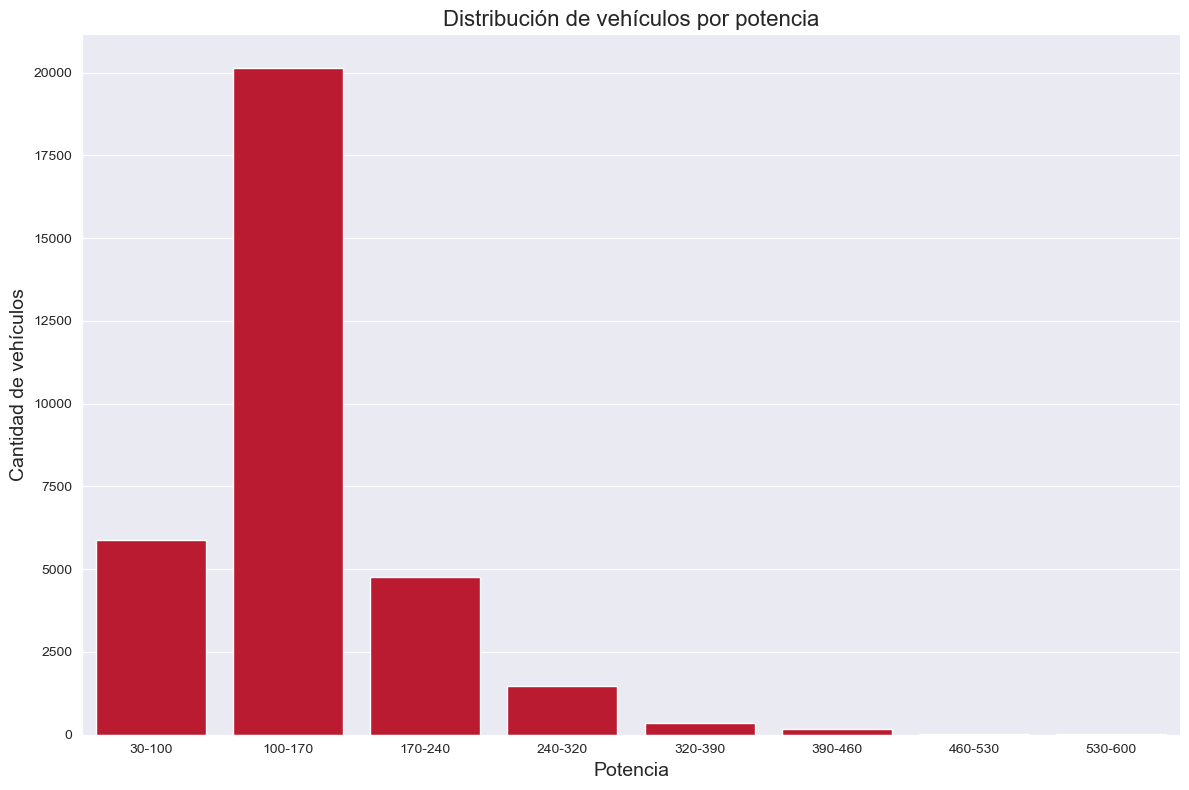

In [26]:
# Definimos los rangos de potencia:
min_potencia = df['potencia'].min()
max_potencia = df['potencia'].max()

num_bins = 8

bins = np.linspace(min_potencia, max_potencia, num_bins + 1) 
bins = np.round(bins, -1) 

labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

df_rangos = df.copy() 
df_rangos['potencia_rango'] = pd.cut(df_rangos['potencia'], bins=bins, labels=labels, right=False)

plt.figure(figsize = (12, 8))

sns.countplot(x=df_rangos["potencia_rango"], order=labels, color=colors[0])

plt.title("Distribución de vehículos por potencia", fontsize=16)
plt.xlabel("Potencia", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.xticks(ha='center') 
plt.tight_layout()

plt.show()

In [27]:
# Num de vehículos con potncia > 330 CV:

df.loc[df.loc[:, "potencia"] > 330, :].count()

marca             499
modelo            499
precio            499
combustible       499
anyo_vehiculo     499
kilometraje       499
potencia          499
num_puertas       499
tipo_cambio       499
color             499
origen_anuncio    499
dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32848 entries, 0 to 40042
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32848 non-null  object 
 1   modelo          32848 non-null  object 
 2   precio          32848 non-null  float64
 3   combustible     32776 non-null  object 
 4   anyo_vehiculo   32847 non-null  float64
 5   kilometraje     32848 non-null  int64  
 6   potencia        32848 non-null  float64
 7   num_puertas     32848 non-null  float64
 8   tipo_cambio     32768 non-null  object 
 9   color           32730 non-null  object 
 10  origen_anuncio  32848 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.0+ MB


#### Año:

In [29]:
# Vemos si hay alguno nulo:

df[df["anyo_vehiculo"].isna()]

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
34438,SEAT,arona,10.021271,Gasolina,NaN,1,115.0,5.0,Manual,naranja,dataset kaggle


Vamos a ver la distribución de valores del campo ```"anyo_vehiculo"```.

Hay uno con valor nulo. Lo eliminamos y convertimos el resto a int:

In [30]:
df = df.dropna(subset=["anyo_vehiculo"])

df["anyo_vehiculo"] = df["anyo_vehiculo"].astype(int)

In [31]:
df["anyo_vehiculo"].value_counts()

anyo_vehiculo
2016    3948
2019    3433
2017    3246
2020    3152
2018    2755
2015    2313
2014    1456
2013    1065
2007    1012
2008     982
2011     960
2010     934
2012     903
2009     899
2006     837
2021     786
2005     766
2004     603
2003     437
2022     405
2002     330
2023     312
2001     255
2000     218
2024     207
1999     164
1998      92
1997      62
1996      50
1993      41
1995      33
1992      29
1994      28
1989      24
1991      24
2025      22
1990      17
1988      11
1987       9
1986       8
1982       7
1985       5
1984       3
1983       3
1980       1
Name: count, dtype: int64

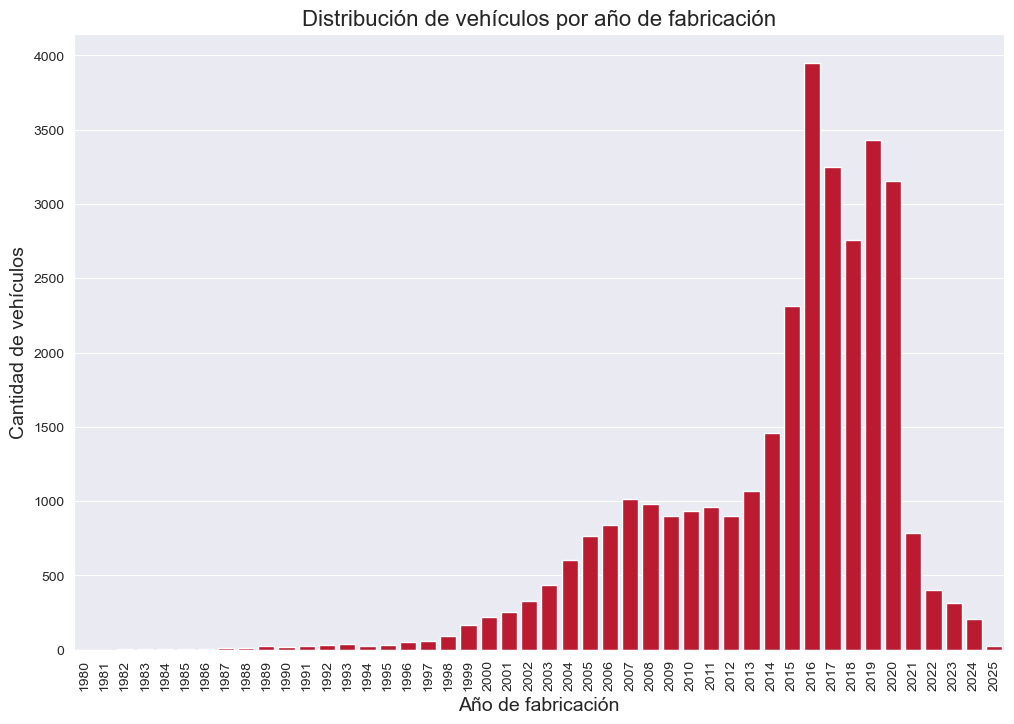

In [32]:
plt.figure(figsize = (12, 8))

rango_años = np.linspace(df["anyo_vehiculo"].min(), df["anyo_vehiculo"].max(), num=int(df["anyo_vehiculo"].max() - df["anyo_vehiculo"].min()) + 1, dtype=int)


sns.countplot(x=df["anyo_vehiculo"], order=rango_años, color=colors[0])

plt.title("Distribución de vehículos por año de fabricación", fontsize=16)
plt.xlabel("Año de fabricación", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=90)  

plt.show()

#### Número de puertas:

Veamos los valores de la siguiente columna no numérica, ```"num_puertas"```:

In [33]:
df["num_puertas"] = df["num_puertas"].astype(int)

df["num_puertas"].value_counts()

num_puertas
5    23739
4     5289
3     2295
2     1524
Name: count, dtype: int64

Vamos a agrupar los coches de 5 puertas con los de 4, y los de 3 con los de 2, ya que la diferencia es que no se cuenta el maletero.

In [34]:
num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
                     
df["num_puertas"] = df["num_puertas"].map(num_puertas)

In [35]:
df["num_puertas"].value_counts()

num_puertas
5    29028
3     3819
Name: count, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32847 entries, 0 to 40042
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32847 non-null  object 
 1   modelo          32847 non-null  object 
 2   precio          32847 non-null  float64
 3   combustible     32775 non-null  object 
 4   anyo_vehiculo   32847 non-null  int32  
 5   kilometraje     32847 non-null  int64  
 6   potencia        32847 non-null  float64
 7   num_puertas     32847 non-null  int64  
 8   tipo_cambio     32767 non-null  object 
 9   color           32729 non-null  object 
 10  origen_anuncio  32847 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 2.9+ MB


### Variables categóricas:

#### Color:

La columna ```"color"``` sigue teniendo bastantes NaN.

In [37]:
# pd.set_option("display.max_rows", None)

df["color"].value_counts()

color
blanco         8640
gris           7859
negro          5482
azul           3815
rojo           1931
               ... 
gg7               1
t1t1              1
191               1
79u               1
mineralgrau       1
Name: count, Length: 320, dtype: int64

Vamos a eliminar la columna color, ya que es una columna categórica con 323 valores únicos y algunos pueden estar en una codificación numérica y otros están mal guardados.

In [38]:
df = df.drop(columns="color")

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32847 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32847 non-null  object 
 1   modelo          32847 non-null  object 
 2   precio          32847 non-null  float64
 3   combustible     32775 non-null  object 
 4   anyo_vehiculo   32847 non-null  int32  
 5   kilometraje     32847 non-null  int64  
 6   potencia        32847 non-null  float64
 7   num_puertas     32847 non-null  int64  
 8   tipo_cambio     32767 non-null  object 
 9   origen_anuncio  32847 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.6+ MB


#### Tipo de cambio:

La columna ```"tipo_cambio"``` también continúa teniendo bastantes NaN.

In [40]:
df["tipo_cambio"].value_counts(dropna=False)

tipo_cambio
Manual        22293
Automático    10474
None             80
Name: count, dtype: int64

Como en la columna ```"tipo_cambio"``` existen muchos coches manuales y automáticos, vamos a eliminar las filas con valores de ```"tipo_cambio"``` nulos (111).

In [41]:
df = df.drop(index=(df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,CITROEN,c4 picasso,8.987072,Diésel,2014,195000,115.0,5,Manual,WebScraping
1,OPEL,corsa,9.391411,Gasolina,2020,32325,100.0,5,Manual,WebScraping
2,OPEL,corsa,9.615139,Gasolina,2022,63540,130.0,5,Automático,WebScraping
3,CITROEN,berlingo,9.209340,Gasolina,2018,110000,110.0,5,Manual,WebScraping
4,AUDI,a3,10.280210,Híbrido,2020,82351,150.0,5,Automático,WebScraping


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32767 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32767 non-null  object 
 1   modelo          32767 non-null  object 
 2   precio          32767 non-null  float64
 3   combustible     32695 non-null  object 
 4   anyo_vehiculo   32767 non-null  int32  
 5   kilometraje     32767 non-null  int64  
 6   potencia        32767 non-null  float64
 7   num_puertas     32767 non-null  int64  
 8   tipo_cambio     32767 non-null  object 
 9   origen_anuncio  32767 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.6+ MB


Ahora que ya no contiene nulos, convertimos a numéricos los valores de la columna ```"tipo_cambio"```, mapeando como 0 los vehículos con cambio "Manual" y 1 los que tienen "Automático":

In [43]:
df["tipo_cambio"].value_counts()

tipo_cambio
Manual        22293
Automático    10474
Name: count, dtype: int64

In [44]:
df["tipo_cambio"] = df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

In [45]:
df["tipo_cambio"].value_counts()

tipo_cambio
0    22293
1    10474
Name: count, dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32767 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32767 non-null  object 
 1   modelo          32767 non-null  object 
 2   precio          32767 non-null  float64
 3   combustible     32695 non-null  object 
 4   anyo_vehiculo   32767 non-null  int32  
 5   kilometraje     32767 non-null  int64  
 6   potencia        32767 non-null  float64
 7   num_puertas     32767 non-null  int64  
 8   tipo_cambio     32767 non-null  int64  
 9   origen_anuncio  32767 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.6+ MB


#### Combustible:

In [47]:
df[df["combustible"].isna()].count()

marca             72
modelo            72
precio            72
combustible        0
anyo_vehiculo     72
kilometraje       72
potencia          72
num_puertas       72
tipo_cambio       72
origen_anuncio    72
dtype: int64

Todavía hay 34 registros con el valor de combustible nulo, de modo que eliminamos estos registros:

In [48]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32695 non-null  object 
 1   modelo          32695 non-null  object 
 2   precio          32695 non-null  float64
 3   combustible     32695 non-null  object 
 4   anyo_vehiculo   32695 non-null  int32  
 5   kilometraje     32695 non-null  int64  
 6   potencia        32695 non-null  float64
 7   num_puertas     32695 non-null  int64  
 8   tipo_cambio     32695 non-null  int64  
 9   origen_anuncio  32695 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.6+ MB


Vemos que nos hemos quedado con 29698 filas de 10 marcas de vehículos. Ya no tenemos valores nulos, ahora vamos a procesar las columnas restantes para que puedan ser usadas en el modelo.

In [49]:
df["combustible"].value_counts()

combustible
Diésel                20938
Gasolina              10640
Híbrido Enchufable      376
Híbrido                 343
Eléctrico               291
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

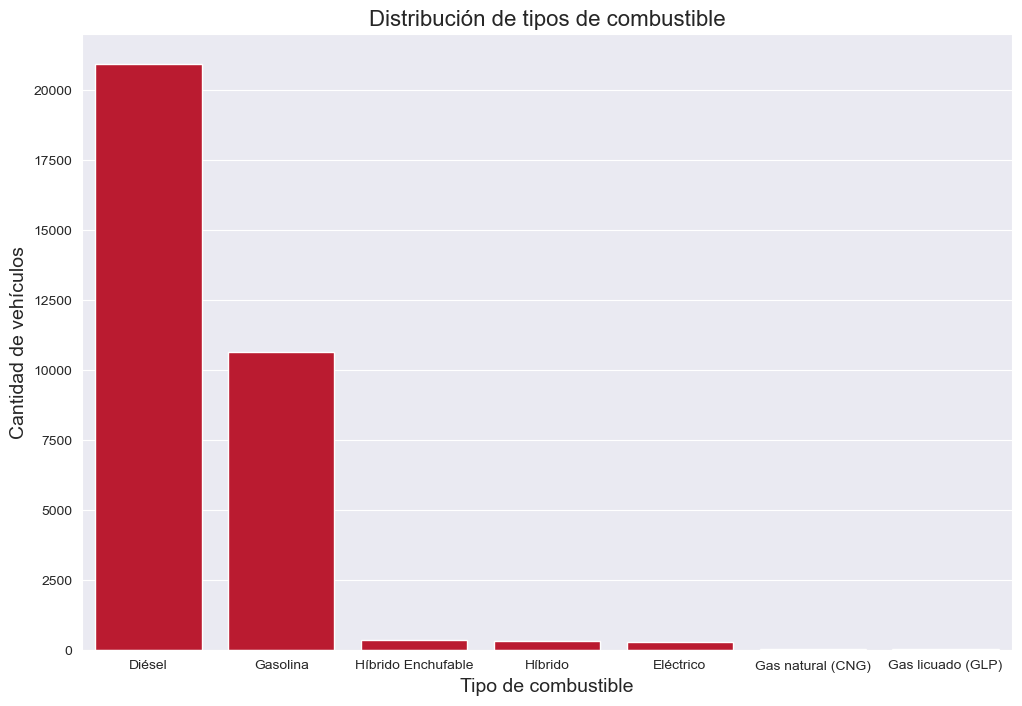

In [50]:
plt.figure(figsize = (12, 8))

sns.countplot(x=df["combustible"], order=df["combustible"].value_counts(ascending=False).index, color=colors[0])

plt.title("Distribución de tipos de combustible", fontsize=16)
plt.xlabel("Tipo de combustible", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.show()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32695 non-null  object 
 1   modelo          32695 non-null  object 
 2   precio          32695 non-null  float64
 3   combustible     32695 non-null  object 
 4   anyo_vehiculo   32695 non-null  int32  
 5   kilometraje     32695 non-null  int64  
 6   potencia        32695 non-null  float64
 7   num_puertas     32695 non-null  int64  
 8   tipo_cambio     32695 non-null  int64  
 9   origen_anuncio  32695 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.6+ MB


Vamos ahora a convertir la columna ```"combustible"``` en numérica a través de un mapeado:

In [52]:
df["combustible"].value_counts()

combustible
Diésel                20938
Gasolina              10640
Híbrido Enchufable      376
Híbrido                 343
Eléctrico               291
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

Vemos cómo predominan los coches de diésel y gasolina.

Convertimos los valores en numéricos utilizando un mapeado:

In [53]:
# Aplicamos un mapeado para la columna "combustible":

tipos_combutible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido Enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
df["combustible"] = df["combustible"].map(tipos_combutible)

In [54]:
df["combustible"].value_counts()

combustible
0    20938
1    10640
4      376
2      343
3      291
6       58
5       49
Name: count, dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32695 non-null  object 
 1   modelo          32695 non-null  object 
 2   precio          32695 non-null  float64
 3   combustible     32695 non-null  int64  
 4   anyo_vehiculo   32695 non-null  int32  
 5   kilometraje     32695 non-null  int64  
 6   potencia        32695 non-null  float64
 7   num_puertas     32695 non-null  int64  
 8   tipo_cambio     32695 non-null  int64  
 9   origen_anuncio  32695 non-null  object 
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 2.6+ MB


#### Marca:

Antes de convertir las columnas ```"marca"``` y ```"modelo"``` en númericas, vamos a guardar en un set las marcas y modelos de coches que quedan en el DataFrame, para luego utilizarlas en la Web App de predicción de precios:

In [56]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,CITROEN,c4 picasso,8.987072,0,2014,195000,115.0,5,0,WebScraping
1,OPEL,corsa,9.391411,1,2020,32325,100.0,5,0,WebScraping
2,OPEL,corsa,9.615139,1,2022,63540,130.0,5,1,WebScraping
3,CITROEN,berlingo,9.209340,1,2018,110000,110.0,5,0,WebScraping
4,AUDI,a3,10.280210,2,2020,82351,150.0,5,1,WebScraping


In [57]:
marca_modelo_set = {}

for index, row in df.iterrows():
    make = row['marca']
    model = row['modelo']
    
    if make not in marca_modelo_set:
        marca_modelo_set[make] = {model}
    else:
        marca_modelo_set[make].add(model)

# Guardamos el set con marcas y modelos en un pkl:

with open('../include/utils/marca_modelo_set.pkl', 'wb') as archivo_salida3:
    pickle.dump(marca_modelo_set, archivo_salida3)

print(marca_modelo_set)

{'CITROEN': {'bx', 'c5 aircross hybrid', 'c3 aircross', 'c5 aircross', 'c2', 'c3 pluriel', 'ds5', 'nemo', 'c5', 'grand c4 picasso', 'ds3', 'c1', 'c4 aircross', 'c-elysee', 'zx', 'ax', 'c-15', 'xantia', 'saxo', 'c4 spacetourer', 'berlingo', 'c4', '2cv', 'c3 picasso', 'c-crosser', 'c3', 'c-zero', 'c4 cactus', 'spacetourer', 'c4 sedan', 'jumpy', 'xsara', 'e-c4', 'xsara picasso', 'ds4', 'jumper', 'c4 picasso', 'c6', 'grand c4 spacetourer', 'c8', 'evasion'}, 'OPEL': {'vivaro', 'meriva', 'crossland x', 'zafira life', 'insignia', 'signum', 'agila', 'gt', 'corsa', 'crossland', 'corsa-e', 'kadett', 'gtc', 'manta', 'monterey', 'grandland x', 'combo life', 'ampera', 'omega', 'zafira-e life', 'mokka x', 'movano', 'cabrio', 'adam', 'combo', 'antara', 'astra', 'zafira tourer', 'tigra', 'mokka', 'karl', 'zafira', 'grandland x phev', 'corsa van', 'frontera', 'vectra'}, 'AUDI': {'a8', 's8', 's7', 'tt rs', 's3', 's6', 's4', 'sq5', 'r8', 'q3 sportback', 'q5', 'a6', 'a5', 'a2', 'q2', 'rs6', 'a6 allroad qu

Una vez guardado este set, empezamos con el análisis y procesado de las variables que utilizaremos en el modelo:

In [58]:
marca_df = df["marca"]
marca_df.value_counts()

marca
VOLKSWAGEN       4312
BMW              4003
MERCEDES-BENZ    3819
AUDI             3331
PEUGEOT          3109
FORD             2947
RENAULT          2947
OPEL             2869
CITROEN          2838
SEAT             2520
Name: count, dtype: int64

Tenemos 72 marcas diferentes de coches. Vamos a hacer un countplot para ver cuántos vehículos tenemos de cada marca:

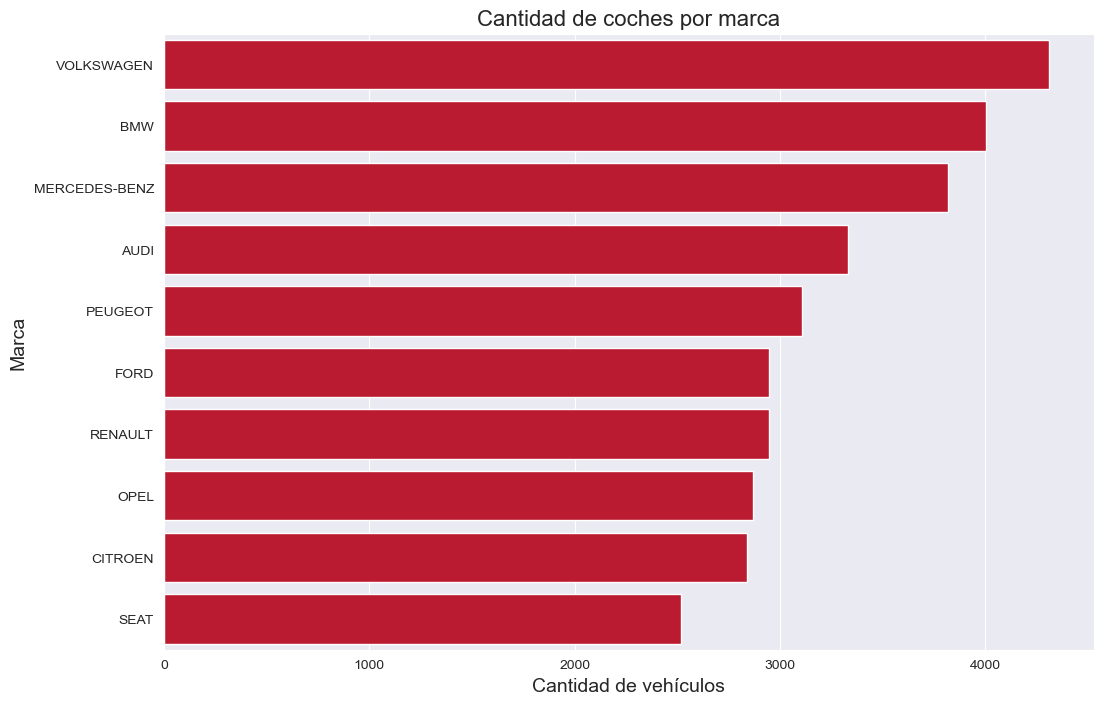

In [59]:
plt.figure(figsize = (12, 8))
sns.countplot(y = marca_df, order=marca_df.value_counts(ascending=False).index, color=colors[0])

plt.title("Cantidad de coches por marca", fontsize=16)
plt.xlabel("Cantidad de vehículos", fontsize=14)
plt.ylabel("Marca", fontsize=14)

plt.show()

En el gráfico vemos cómo tenemos muchos coches registrados en la base de datos para cada una de las 10 marcas.

Vamos a asignar un valor numérico a cada marca para poder utilizar dicha columna como feature del modelo:

In [60]:
# Asignamos cada marca a un valor numérico utilizando LabelEncoder:

from sklearn.preprocessing import LabelEncoder

encoder_marca = LabelEncoder()
encoder_marca.fit(df["marca"].sort_values(ascending=False))
list(encoder_marca.classes_)
df["marca"] = encoder_marca.transform(df["marca"])

# Guardamos el LabelEncoder para poder utilizarlo después en otros archivos:

with open('../include/utils/label_encoder_marca.pkl', 'wb') as archivo_salida1:
    pickle.dump(encoder_marca, archivo_salida1)

df["marca"].value_counts()

marca
9    4312
1    4003
4    3819
0    3331
6    3109
3    2947
7    2947
5    2869
2    2838
8    2520
Name: count, dtype: int64

In [61]:
# muestra las marcas originales

print(encoder_marca.classes_) 


['AUDI' 'BMW' 'CITROEN' 'FORD' 'MERCEDES-BENZ' 'OPEL' 'PEUGEOT' 'RENAULT'
 'SEAT' 'VOLKSWAGEN']


In [62]:
# Para visualizar el mapping de marca con LabelEncoder

list(encoder_marca.inverse_transform([0]))

['AUDI']

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32695 non-null  int32  
 1   modelo          32695 non-null  object 
 2   precio          32695 non-null  float64
 3   combustible     32695 non-null  int64  
 4   anyo_vehiculo   32695 non-null  int32  
 5   kilometraje     32695 non-null  int64  
 6   potencia        32695 non-null  float64
 7   num_puertas     32695 non-null  int64  
 8   tipo_cambio     32695 non-null  int64  
 9   origen_anuncio  32695 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(2)
memory usage: 2.5+ MB


#### Modelo:

Vamos ahora con la columna ```"modelo"```:

In [64]:
df["modelo"].value_counts()

modelo
golf         1433
serie 3      1036
ibiza         872
focus         850
leon          849
             ... 
lt              1
s7              1
gle coupe       1
140d            1
r21             1
Name: count, Length: 367, dtype: int64

Tenemos 373 modelos diferentes. En esta ocasión no realizamos el countplot ya que es información demasiado específica para visualizar.

Aunque son muchos valores diferentes, por el momento, realizamos otro Label Encoder. Más adelante veremos si es una columna que aporte información al modelo.

In [65]:
from sklearn.preprocessing import LabelEncoder

encoder_modelo = LabelEncoder()
encoder_modelo.fit(df["modelo"].sort_values(ascending=False))
list(encoder_modelo.classes_)
df["modelo"] = encoder_modelo.transform(df["modelo"])

# Guardamos el Encoding:

with open('../include/utils/label_encoder_modelo.pkl', 'wb') as archivo_salida2:
    pickle.dump(encoder_modelo, archivo_salida2)

df["modelo"].value_counts()

modelo
194    1433
305    1036
214     872
184     850
237     849
       ... 
238       1
294       1
193       1
6         1
275       1
Name: count, Length: 367, dtype: int64

In [66]:
# Para visualizar el mapping de model con LabelEncoder

list(encoder_modelo.inverse_transform([196]))

['golf sportsvan']

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           32695 non-null  int32  
 1   modelo          32695 non-null  int32  
 2   precio          32695 non-null  float64
 3   combustible     32695 non-null  int64  
 4   anyo_vehiculo   32695 non-null  int32  
 5   kilometraje     32695 non-null  int64  
 6   potencia        32695 non-null  float64
 7   num_puertas     32695 non-null  int64  
 8   tipo_cambio     32695 non-null  int64  
 9   origen_anuncio  32695 non-null  object 
dtypes: float64(2), int32(3), int64(4), object(1)
memory usage: 2.4+ MB


#### Origen anuncio:

Tan solo falta la columna ```"origen_anuncio"```, que vamos a eliminar ya que sólo la hemos mantenido para diferenciar el origen del anuncio, pero no la queremos utilizar en el modelo predictivo.

In [68]:
df.drop(columns=["origen_anuncio"], inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32695 entries, 0 to 40042
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   marca          32695 non-null  int32  
 1   modelo         32695 non-null  int32  
 2   precio         32695 non-null  float64
 3   combustible    32695 non-null  int64  
 4   anyo_vehiculo  32695 non-null  int32  
 5   kilometraje    32695 non-null  int64  
 6   potencia       32695 non-null  float64
 7   num_puertas    32695 non-null  int64  
 8   tipo_cambio    32695 non-null  int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 2.1 MB


Ya tenemos nuestro DataFrame con todas las columnas de tipo numérico, listas para ser utilizadas por el modelo (después de escalar, dividir los conjuntos de train y test, etc.).

Guardamos el DataFrame.

In [70]:
# Guardamos el DataFrame transformado

df.to_csv("../include/data/processed/df_pre_modelo.csv")

## 3. Modelos predictivos.

In [71]:
df = pd.read_csv("../include/data/processed/df_pre_modelo.csv", index_col=0).reset_index(drop=True)
df

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,2,100,8.987072,0,2014,195000,115.0,5,0
1,5,155,9.391411,1,2020,32325,100.0,5,0
2,5,155,9.615139,1,2022,63540,130.0,5,1
3,2,81,9.209340,1,2018,110000,110.0,5,0
4,0,55,10.280210,2,2020,82351,150.0,5,1
...,...,...,...,...,...,...,...,...,...
32690,8,237,9.830379,0,2019,21153,115.0,5,0
32691,7,235,9.581904,0,2015,68750,150.0,3,0
32692,6,5,9.305651,1,2019,21422,72.0,5,0
32693,0,285,10.776871,1,2013,47900,450.0,5,1


Ya tenemos 9 columnas numéricas con las que poder predecir la columna target (```"precio"```).

Vamos ahora a dividir los datos de X (features) e y (target).

In [72]:
X = df.drop("precio", axis=1)
y = df["precio"]

In [73]:
X

,marca,modelo,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,2,100,0,2014,195000,115.0,5,0
1,5,155,1,2020,32325,100.0,5,0
2,5,155,1,2022,63540,130.0,5,1
3,2,81,1,2018,110000,110.0,5,0
4,0,55,2,2020,82351,150.0,5,1
...,...,...,...,...,...,...,...,...
32690,8,237,0,2019,21153,115.0,5,0
32691,7,235,0,2015,68750,150.0,3,0
32692,6,5,1,2019,21422,72.0,5,0
32693,0,285,1,2013,47900,450.0,5,1


Vamos a realizar un heatmap de las features de nuestro modelo, para ver cómo de correlacionadas están entre ellas:

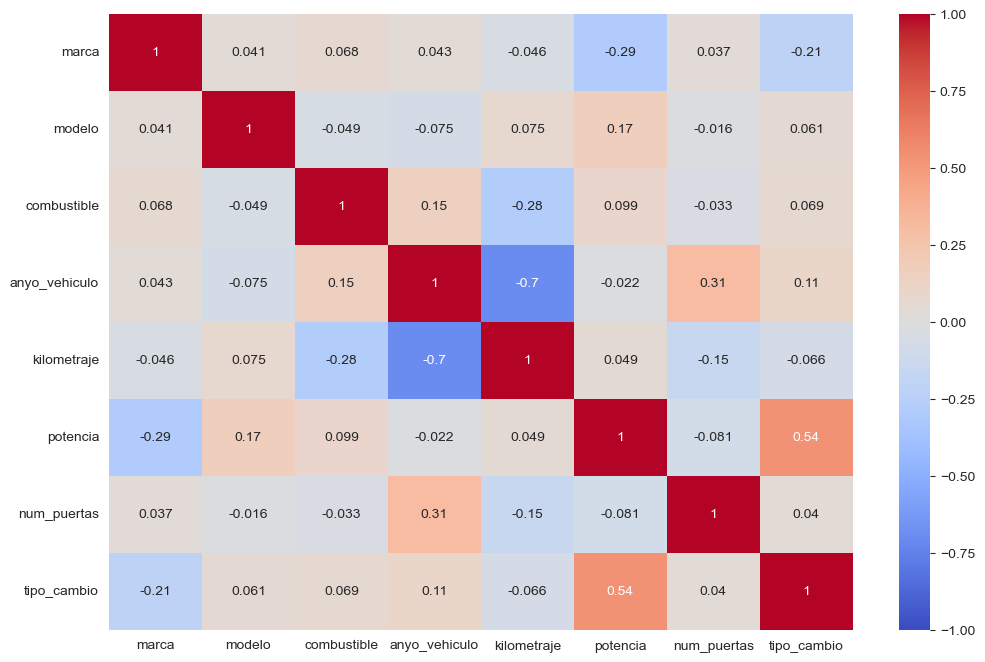

In [74]:
matriz_corr = X.corr(numeric_only=True).round(decimals=3)

plt.figure(figsize=(12, 8))

sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Vemos que la mayor correlación se da entre los kilómetros y el año del vehículo, y es negativa. Esto es lógico, ya que cuanto mayor sea el año (y más nuevo el coche), menor suele ser el número de kilómetros realizados.

Además de esto, cabe mencionar que ninguna de las correlaciones es lo suficientemente elevada como para plantearse prescindir de alguna columna.

Separamos los datos de train y test:

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26156, 8)
(6539, 8)
(26156,)
(6539,)


Vamos a escalar los datos de X entre 0 y 1:

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

# Guardamos el Scaler

with open('../include/utils/scaler.pkl', 'wb') as archivo_salida4:
    pickle.dump(scaler, archivo_salida4)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
X_train

array([[0.        , 0.15027322, 0.        , ..., 0.21006944, 0.        ,
        0.        ],
       [0.        , 0.16393443, 0.        , ..., 0.34027778, 1.        ,
        1.        ],
       [0.44444444, 0.35245902, 0.        , ..., 0.18576389, 1.        ,
        1.        ],
       ...,
       [1.        , 0.89344262, 0.        , ..., 0.24479167, 1.        ,
        0.        ],
       [0.77777778, 0.67486339, 0.16666667, ..., 0.14930556, 1.        ,
        0.        ],
       [0.11111111, 0.95355191, 0.        , ..., 0.21006944, 1.        ,
        0.        ]])

Comenzamos la seleción del modelo de regresión. Para ello, probamos varias parametrizaciones de modelos utilizando GridSearchCV.

In [78]:
# Importamos los modelos de regresión que utilizaremos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [66]:
# LinearRegression??

### 3.1. Linear Regression.

In [67]:
# Linear Regression

param = {}

gs_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_lin_reg.fit(X_train, y_train)

y_pred = gs_lin_reg.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.11461013111805038
RMSE: 0.33854118083041296
MAE: 0.23870741331869805
MAPE: 0.0261976080078374
r2 score: 0.8350559570096232


### 3.2. Polynomial Regression.

In [70]:
# Polynomial Regression

param = {}

for degree in range(1, 6):

    poly_feat = PolynomialFeatures(degree = degree)

    poly_feat.fit(X_train)

    X_train_poly = poly_feat.transform(X_train)
    X_test_poly = poly_feat.transform(X_test)


    gs_poly = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

    gs_poly.fit(X_train_poly, y_train)

    y_pred = gs_poly.predict(X_test_poly)

    print(f"Poly Degree {degree}:")

    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

    print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")
    print(" ")

Poly Degree 1:
MSE: 0.11461013111804957
RMSE: 0.3385411808304118
MAE: 0.23870741331869574
MAPE: 0.026197608007837523
r2 score: 0.8350559570096244
 
Poly Degree 2:
MSE: 0.08969448465760148
RMSE: 0.2994903748997645
MAE: 0.20880008952004817
MAPE: 0.02296056967485811
r2 score: 0.8709139341431829
 
Poly Degree 3:
MSE: 0.07531957401464005
RMSE: 0.2744441182001175
MAE: 0.1849798011154453
MAPE: 0.02045669961142007
r2 score: 0.891601947113286
 
Poly Degree 4:
MSE: 0.07132395700256919
RMSE: 0.26706545452860275
MAE: 0.17608620688370796
MAPE: 0.019463395613474915
r2 score: 0.8973523394894474
 
Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461
 


In [71]:
# El mejor es el de grado 5:

degree = 5
poly_feat = PolynomialFeatures(degree = degree)

poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_test_poly = poly_feat.transform(X_test)


best_poly_model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

best_poly_model.fit(X_train_poly, y_train)

y_pred = best_poly_model.predict(X_test_poly)

print(f"Poly Degree {degree}:")

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461


### 3.3. RandomForest.

In [79]:
# RandomForest

param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

gs_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_rf.fit(X_train, y_train)

y_pred = gs_rf.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04659971668038285
RMSE: 0.2158696752218404
MAE: 0.13772853732392737
MAPE: 0.015411189923661412
r2 score: 0.9266683436310879


In [80]:
gs_rf.best_params_

{'max_depth': 33, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}

### 3.4. ADA Boost Regression.

In [74]:
# ADA

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_ada = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_ada.fit(X_train, y_train)

y_pred = gs_ada.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.12913964574632744
RMSE: 0.3593600502926382
MAE: 0.2685003649807258
MAPE: 0.029238076979689855
r2 score: 0.8141454418387843


In [75]:
gs_ada.best_score_

-0.1272252746038315

In [76]:
gs_ada.best_params_

{'learning_rate': 0.4, 'n_estimators': 100, 'random_state': 42}

### 3.5. Gradient Boosting Regression.

In [77]:
# Gradient Boost

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_gb.fit(X_train, y_train)

y_pred = gs_gb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04443449167430775
RMSE: 0.210794904289235
MAE: 0.14072856066304698
MAPE: 0.015624269353422865
r2 score: 0.9360509875219203


### 3.6. XGradient Boosting Regression.

In [81]:
# XG Boost

param = {}

gs_xgb = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_xgb.fit(X_train, y_train)

y_pred = gs_xgb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04046446481334211
RMSE: 0.20115781071920152
MAE: 0.13326713803530943
MAPE: 0.01487794831453516
r2 score: 0.9363230843398432


### 3.7. Voting.

In [79]:
# Voting

# param = {"estimators":[gs_lin_reg.best_estimator_, best_poly_model.best_estimator_, gs_rf.best_estimator_, gs_ada.best_estimator_, gs_gb.best_estimator_, gs_xgb.best_estimator_],
#          "n_jobs":[-1]}

gs_voting = VotingRegressor(estimators=[("lin_reg", gs_lin_reg.best_estimator_), ("rf", gs_rf.best_estimator_), ("ada", gs_ada.best_estimator_), ("gb", gs_gb.best_estimator_), ("xgb", gs_xgb.best_estimator_)],
                            n_jobs=-1,)

gs_voting.fit(X_train, y_train)

y_pred = gs_voting.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.053497701952873
RMSE: 0.23129570240900066
MAE: 0.15609829313481452
MAPE: 0.017271840387161876
r2 score: 0.9230074412731275


El Voting da peor. El modelo con mejores métricas es el Gradient Boosting Regressor, aunque el XGradient Boosting y el RandomForest también estaba cerca. 

## 4. Selección y análisis del mejor modelo.

### 4.1. Selección de modelo:

Vamos a comparar en una tabla el resultado obtenido para el MSE de test en cada modelo, ya que es la métrica que estamos utilizando, con el fin de elegir el mejor:

In [2]:
import pandas as pd

In [ ]:
df_comp_modelos_log = pd.DataFrame({"Modelo":["Linear Regression", "Polynomial Regression (grado 5)", "RandomForest", "ADA Boost", "Gradient Boost", "XG Boost", "Voting"],
                                "MAE":[0.2387, 0.1714, 0.1432, 0.2685, 0.1407, 0.1376, 0.1561],
                                "RMSE":[0.3385, 0.2669, 0.2290, 0.3594, 0.2108, 0.2135, 0.2313],
                                "r2 score":[0.8351, 0.8975, 0.9245, 0.8142, 0.9361, 0.9344, 0.9230]})

df_comp_modelos_log = df_comp_modelos_log.sort_values("MAE", ascending=True).reset_index(drop=True)
df_comp_modelos_log

,Modelo,RMSE,MAE,r2 score
0,XG Boost,0.2135,0.1376,0.9344
1,Gradient Boost,0.2108,0.1407,0.9361
2,RandomForest,0.2290,0.1432,0.9245
3,Voting,0.2313,0.1561,0.9230
4,Polynomial Regression (grado 5),0.2669,0.1714,0.8975
5,Linear Regression,0.3385,0.2387,0.8351
6,ADA Boost,0.3594,0.2685,0.8142


Vemos que el mejor modelo es el Gradient Boost, aunque está muy cerca el XGBoost. Vamos a quedarnos con el XGBoost, ya que su tiempo de entrenamiento es mucho menor y los resultados muy similares, y también con el RandomForest, ya que su funcionamiento es distinto y sus resultados están bastante cerca, por lo que puede sernos útil para comparar.

Cabe destacar que el MAE representado en la tabla anterior no se corresponde con el error medio en la predicción del modelo sobre el precio del vehículo, ya que hemos aplicado una transformación logarítmica a este precio. Más adelante veremos el MAE y el MSE reales del mejor modelo, una vez aplicada la transformación inversa. 

Vamos a ver si podemos mejorar algo de estos dos modelos mirando la importancia de las columnas (features) y realizando alguna modificación. Comenzamos con el RandomForest:

In [82]:
gs_rf.best_estimator_.feature_importances_

array([0.02738064, 0.03375813, 0.00549048, 0.57843518, 0.08085046,
       0.26449185, 0.00348913, 0.00610414])

Realizamos un dataframe con la importancia de las cada columna en el modelo RandomForest:

In [83]:
df_feat_imp_rf = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, index=X.columns)
df_feat_imp_rf = df_feat_imp_rf.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp_rf

,Feature Importance
anyo_vehiculo,0.578435
potencia,0.264492
kilometraje,0.080850
modelo,0.033758
marca,0.027381
tipo_cambio,0.006104
combustible,0.005490
num_puertas,0.003489


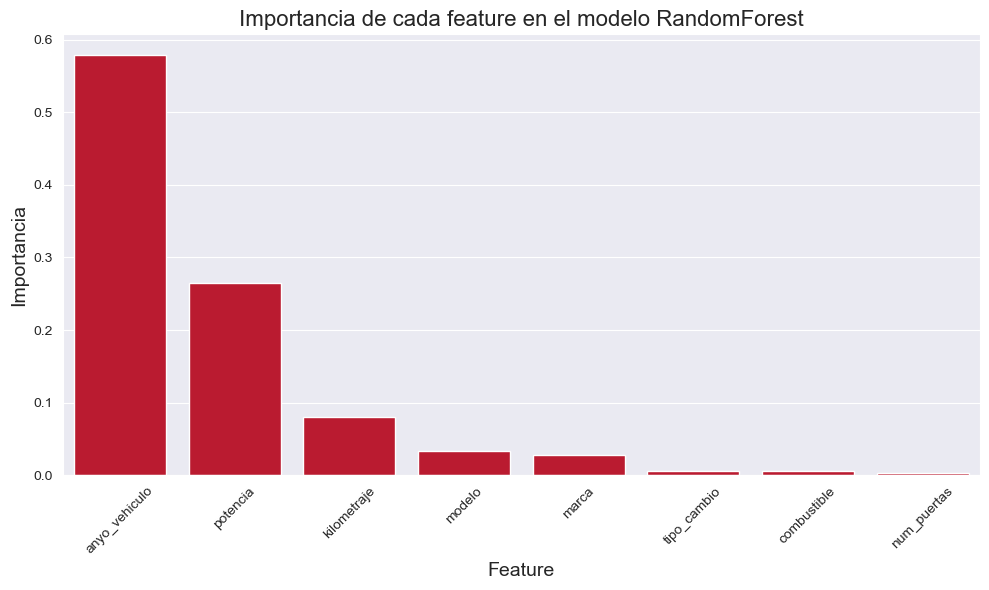

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 


df_feat_imp_rf = df_feat_imp_rf.reset_index() 
df_feat_imp_rf.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo RandomForest", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa cómo las columnas con más importancia en el precio de un coche de segunda mano son, según nuestro modelo RandomForest, el año de matriculación, potencia del motor y kms recorridos. Las columnas de modelo y marca del coche también tienen algo de importancia, y las demás (tipo de cambio, combustible y número de puertas) tienen una importancia mucho menor.

Por esto, vamos a probar a hacer un Random Forest, con la misma parametrización que el mejor de antes, pero quitando las columnas menos importantes: ```["tipo_cambio", "combustible", "num_puertas"]```, a ver si mejora el modelo.

In [91]:
# RF 2

X_rf_2 = X.drop(columns=["tipo_cambio", "combustible", "num_puertas"])
X_rf_2

,marca,modelo,anyo_vehiculo,kilometraje,potencia
0,1,356,2021.0,33200,190.0
1,6,29,2016.0,127300,110.0
2,7,143,2022.0,123000,100.0
3,2,92,2022.0,18150,83.0
4,9,110,2023.0,12000,150.0
...,...,...,...,...,...
29694,8,239,2019.0,21153,115.0
29695,7,237,2015.0,68750,150.0
29696,6,5,2019.0,21422,72.0
29697,0,289,2013.0,47900,450.0


In [92]:
from sklearn.model_selection import train_test_split

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf_2, y, test_size=0.2, random_state=42)

print(X_train_rf2.shape)
print(X_test_rf2.shape)
print(y_train_rf2.shape)
print(y_test_rf2.shape)

(23759, 5)
(5940, 5)
(23759,)
(5940,)


In [93]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_rf2)
X_train_rf2 = scaler.transform(X_train_rf2)
X_test_rf2 = scaler.transform(X_test_rf2)

In [94]:
# RandomForest

# param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

rf2 = RandomForestRegressor(n_estimators=300, max_depth=33, n_jobs=-1, random_state=42)

rf2.fit(X_train_rf2, y_train_rf2)

y_pred_rf2 = rf2.predict(X_test_rf2)

print(f"MSE: {metrics.mean_squared_error(y_test_rf2, y_pred_rf2)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_rf2, y_pred_rf2))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_rf2, y_pred_rf2)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_rf2, y_pred_rf2)}")

print(f"r2 score: {metrics.r2_score(y_test_rf2, y_pred_rf2)}")

MSE: 0.055758710357681825
RMSE: 0.23613282354997117
MAE: 0.14799043130934064
MAPE: 0.016508326874130987
r2 score: 0.9197534543534175


### 4.2. Análisis del modelo definitivo:

Obtenemos un MSE más elevado que antes, por lo que no mejora. Nos quedamos entonces el XG Boost, que era el segundo modelo con el MSE más bajo pero más rápido que el primero. Vamos a ver la importancia de las features en este modelo:

In [85]:
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04046446481334211
RMSE: 0.20115781071920152
MAE: 0.13326713803530943
MAPE: 0.01487794831453516
r2 score: 0.9363230843398432


In [86]:
X.columns

Index(['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje',
       'potencia', 'num_puertas', 'tipo_cambio'],
      dtype='object')

In [87]:
xgb_model.feature_importances_

array([0.04494654, 0.01821221, 0.01724326, 0.3960624 , 0.03480169,
       0.17668569, 0.01996149, 0.29208672], dtype=float32)

In [88]:
df_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X.columns)
df_feat_imp = df_feat_imp.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp

,Feature Importance
anyo_vehiculo,0.396062
tipo_cambio,0.292087
potencia,0.176686
marca,0.044947
kilometraje,0.034802
num_puertas,0.019961
modelo,0.018212
combustible,0.017243


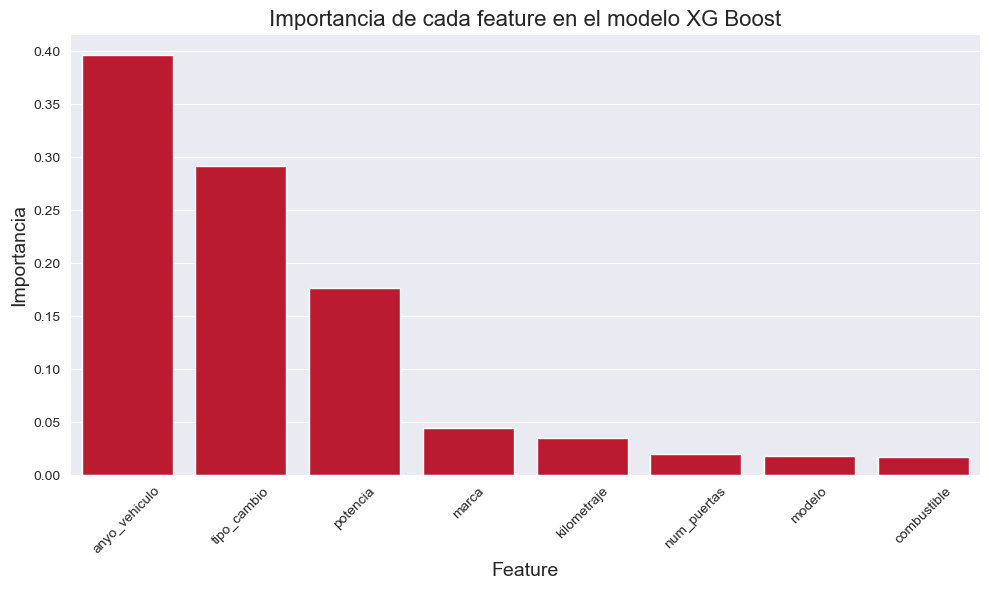

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

df_feat_imp = df_feat_imp.reset_index()
df_feat_imp.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo XG Boost", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


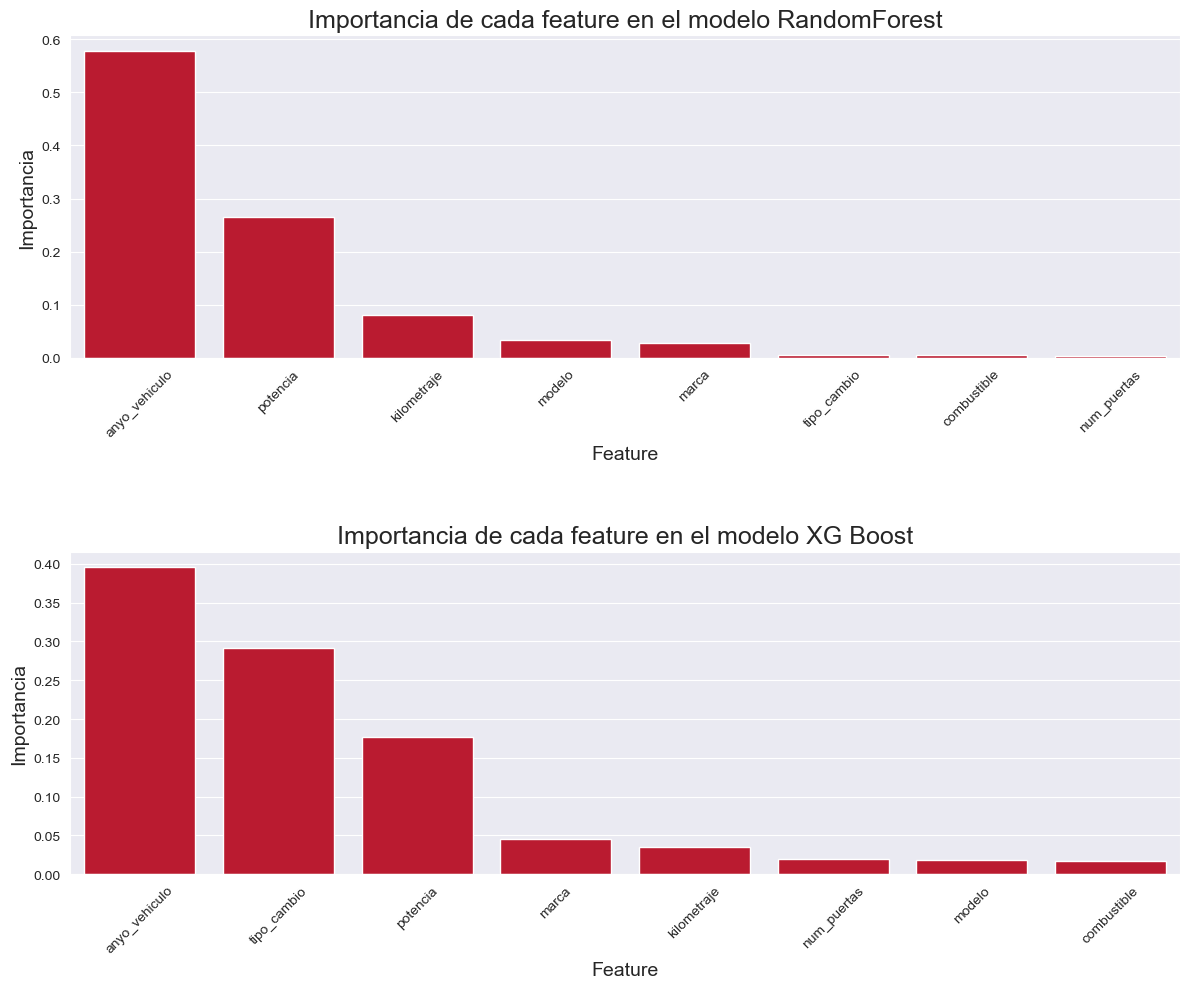

In [100]:
# Comparativa entre importancias del Randomforest y XG Boost:

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que estos DataFrames ya tienen una columna 'Feature'
# Si no, usa reset_index() solo si el índice representa las features

# Crear la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Gráfico 1 - RandomForest
sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0], ax=axes[0])
axes[0].set_title("Importancia de cada feature en el modelo RandomForest", fontsize=18)
axes[0].set_xlabel("Feature", fontsize=14)
axes[0].set_ylabel("Importancia", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2 - XGBoost
sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0], ax=axes[1])
axes[1].set_title("Importancia de cada feature en el modelo XG Boost", fontsize=18)
axes[1].set_xlabel("Feature", fontsize=14)
axes[1].set_ylabel("Importancia", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)  # aumenta el espacio vertical entre subplots
plt.show()


Ahora observamos que las columnas más importantes siguen siendo ```"anyo_vehiculo"``` y ```"potencia"```. Sin embargo, el XGBoost le da mucha más importancia a la columna ```"tipo_cambio"``` que el RandomForest previo, y menos a la columna ```"kilometraje"```. Además la importancia de las columnas menos importantes es más elevada que en el anterior modelo, por lo que no descartaremos ninguna de estas columnas.

Vamos a deshacer la transformación que realizamos en la columna ```"precio"``` (target) para ver la dimensión real de nuestras métricas:

In [104]:
y_pred = xgb_model.predict(X_test)

# Deshacemos la transformación logarítmica:
y_test_final = np.exp(y_test)
y_pred_final = np.exp(y_pred)

# Claculamos las métricas reales:
print(f"MSE: {metrics.mean_squared_error(y_test_final, y_pred_final)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_final, y_pred_final)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_final, y_pred_final)}")

print(f"r2 score: {metrics.r2_score(y_test_final, y_pred_final)}")

MSE: 14256628.19307195
RMSE: 3775.7950411895968
MAE: 1872.9885921902128
MAPE: 0.1405485106362972
r2 score: 0.9315665938523535


Vemos que el MAE = 1873 euros. Esto significa que para cada vehículo nos podemos ir esa cantidad de dinero de media en la predicción. 

El RMSE es algo mayor, 3776 euros, lo cual se debe a que existen unos pocos coches cuyo error es alto, y al hacer el error cuadrático este error se hace más grande.

En cuanto al MAPE, nos indica que nuestro modelo tiene un % de error medio del 14.05% sobre el precio del vehículo, el cual es algo elevado.

Vamos a exportar el modelo final:

In [107]:
import pickle

# Guardamos el modelo final:

with open("../include/model/modelo_final.pkl", 'wb') as archivo_salida:
    pickle.dump(xgb_model, archivo_salida)


Creamos una función que nos permita meter nuevos inputs en el formato de nuestro DataFrame inicial y extraer las variables para pasar directamente al modelo.

Además, creamos otras dos funciones: una para realizar predicciones y otra para destransformar la columna target ```"precio"```.

In [120]:
# Función para transformar un df con nuevos inputs de la base de datos en X, y para pasar al modelo.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle



def new_input_clean(input_df):
    '''
    Introduce los nuevos inputs en formato DataFrame con las columnas iniciales y devuelve los datos listos para introducirlos al modelo.

    El input DataFrame debe contener al menos las columnas (['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 
    'num_puertas', 'tipo_cambio'])
    '''

    excepciones = ['marca', 'modelo', 'precio', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 'num_puertas', 'tipo_cambio']

    # Reemplazar NaN con 0 excepto en las columnas de excepciones (las que utiliza el modelo)
    input_df = input_df.fillna({col: 0 for col in input_df.columns if col not in excepciones})


    input_df = input_df[excepciones]
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
    input_df = input_df.dropna()

    # Importamos los encodings hechos antes:
    encoder_marca = pickle.load(open("../include/utils/label_encoder_marca.pkl", 'rb'))
    encoder_modelo = pickle.load(open("../include/utils/label_encoder_modelo.pkl", 'rb'))

    list(encoder_marca.classes_)
    input_df["marca"] = encoder_marca.transform(input_df["marca"])

    list(encoder_modelo.classes_)
    input_df["modelo"] = encoder_modelo.transform(input_df["modelo"])

    tipos_combustible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
    input_df["combustible"] = input_df["combustible"].map(tipos_combustible)

    num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
    
    input_df["num_puertas"] = input_df["num_puertas"].map(num_puertas)
    
    input_df["tipo_cambio"] = input_df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

    input_df["precio"] = np.log(input_df["precio"])

    X_input = input_df.drop("precio", axis=1)
    y_input = input_df["precio"]
    

    scaler = pickle.load(open("../include/utils/scaler.pkl", 'rb'))

    X_input = scaler.transform(X_input)

    return [X_input, y_input]

# Función para hacer predicciones

def predict(loaded_model, X_input):
    return loaded_model.predict(X_input)

# Función para deshacer la transformación y devolver el precio:

import numpy as np

def destransformar_y(y_out):
    return np.exp(y_out)

Vamos ahora a cargar el modelo y probarlo con un DataFrame de prueba con coches, para ver el precio que predice. 

In [121]:
import pickle

loaded_model = pickle.load(open("../include/model/modelo_final.pkl", 'rb'))

In [122]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [123]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
--where
--fecha_carga > '2025-05-11 22:33:00'
order by
    fecha_carga desc
;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df_prueba = df.head()

df_prueba

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,Diesel,2023.0,12000,150.0,4.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


In [124]:
X_input, y_input = new_input_clean(input_df=df_prueba)

In [125]:
predictions = loaded_model.predict(X_input)
predictions

array([10.6165085,  9.09715  ,  9.384863 ,  9.533099 , 10.874894 ],
      dtype=float32)

In [126]:
y_prueba = destransformar_y(predictions).round(0)
y_prueba

array([40803.,  8930., 11907., 13809., 52833.], dtype=float32)

Insertamos las predicciones realizadas en la columna ```"precio_predicho"```, al lado de la columna target ```"precio"```:

In [130]:
df_prueba.insert(4, "precio_predicho", y_prueba)
df_prueba.to_csv("../include/data/processed/df_prueba_pred.csv")
df_prueba

,pk_anuncio_id,marca,modelo,precio,precio_predicho,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,40803.0,Híbrido,2021.0,33200,190.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,8930.0,Gasolina,2016.0,127300,110.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,11907.0,Diésel,2022.0,123000,100.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,13809.0,Gasolina,2022.0,18150,83.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,52833.0,Diesel,2023.0,12000,150.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


Vemos que los precios que predice el modelo se ajustan bastante a los reales. Para el vehículo VolksWagen California no lo predice bien, lo cual es más común que pase para vehículos fuera del rango de precio entre 5.000 y 25.000 euros, que era donde más cantidad había.

Registros de VolksWagen California:

In [133]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
where
    marca = 'VOLKSWAGEN'
    and modelo = 'california'
;
"""

# Leemos los resultados en un DataFrame de pandas
df_vw_california = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):

# df_vw_california

## Idea: división en segmentos.

1. Segmento medio: hasta 30k eur.
2. Segmento premium: desde 30k eur.